In [16]:
import os
from IPython.display import Image as ipy_image
from IPython.display import display

from utils.demo_util import get_shape_comp_model, get_shape_comp_opt, make_dummy_batch
from utils.qual_util import load_bert2vq_model, get_lang_prob, save_mesh_as_gif
from utils.util import seed_everything
from utils.util_3d import init_mesh_renderer, sdf_to_mesh

%reload_ext autoreload
%autoreload 2

In [17]:
seed_everything(111)

res_dir = 'results'
if not os.path.exists(res_dir): os.makedirs(res_dir)

gpu_id = 0
nimgs=6

In [18]:
opt = get_shape_comp_opt(gpu_id=gpu_id)
opt.dataset_mode = "shapenet_lang"
model = get_shape_comp_model(opt)    
model.eval()

""" setup renderer """
dist, elev, azim = 1.7, 20, 20
mesh_renderer = init_mesh_renderer(image_size=256, dist=dist, elev=elev, azim=azim, device=opt.device)


bert2vq = load_bert2vq_model(opt)

[*] Enc has Attn at i_level, i_block: 3, 0
Working with z of shape (1, 256, 8, 8, 8) = 131072 dimensions.
[*] Dec has Attn at i_level, i_block: 3, 0
[*] VQVAE: weight successfully load from: saved_ckpt/pvqvae-snet-all-LR1e-4-T0.2-rerun-epoch140.pth
[*] Model has been created: Rand-Transformer-Model
[*] "rand_tf" initialized.
[*] weight successfully load from: saved_ckpt/rand_tf-snet_code-all-LR1e-4-clean-epoch200.pth


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[*] autoregressively inferencing...: 100%|██████████| 512/512 [00:08<00:00, 60.60it/s] 


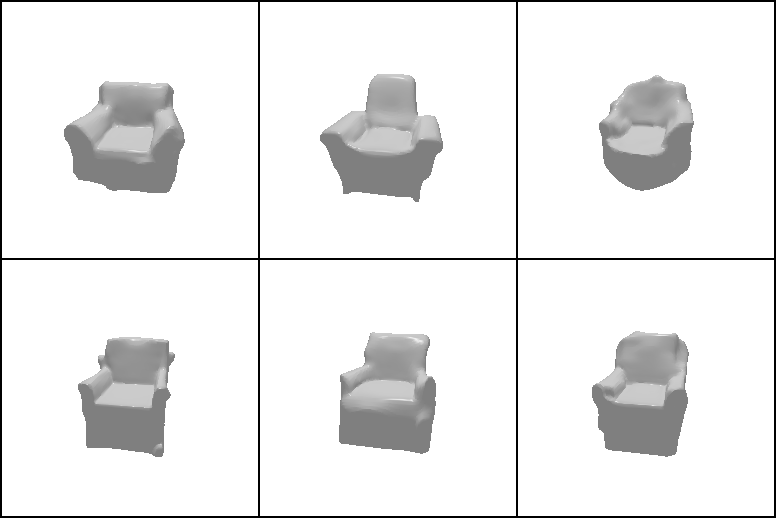

In [19]:
test_data = make_dummy_batch(nimgs)

text_conditional = "Couch with round arms"
lang_conditional_prob = get_lang_prob(bert2vq,text_conditional)
lang_conditional_prob = lang_conditional_prob.repeat(1, nimgs, 1)

topk =10
alpha = .5

model.inference(test_data, topk=topk, prob=lang_conditional_prob, alpha=alpha)
gen_mesh = sdf_to_mesh(model.x_recon_tf)

gen_gif_name = f'{res_dir}/lang-guided-gen.gif'
save_mesh_as_gif(mesh_renderer, gen_mesh, nrow=3, out_name=gen_gif_name)

for name in [gen_gif_name]:
    display(ipy_image(name))